In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, LSTM, Dense, Flatten, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths to dataset folders
TRAIN_DIR = "C:\\Users\\salag\\OneDrive\\Desktop\\final\\data\\train"
TEST_DIR = "C:\\Users\\salag\\OneDrive\\Desktop\\final\\data\\test"
VAL_DIR = "C:\\Users\\salag\\OneDrive\\Desktop\\final\\data\\val"

# Hyperparameters
IMG_SIZE = 64
CHANNELS = 3
SEQUENCE_LENGTH = 40  # Number of frames per video
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.001

# Get unique class labels
CLASSES = sorted(os.listdir(TRAIN_DIR))  # List of class names
NUM_CLASSES = len(CLASSES)

# Map class labels to integer indices
class_to_idx = {label: idx for idx, label in enumerate(CLASSES)}

# Frame extraction function
def extract_frames(video_path, img_size, sequence_length):
    frames_list = []
    print(video_path)
    video_reader = cv2.VideoCapture(video_path)
    
    # Check if the video file is accessible
    if not video_reader.isOpened():
        print(f"Failed to open video: {video_path}")
        return frames_list

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    print(f"Extracting frames from {video_path}...")
    print(f"Total frames in video: {video_frames_count}")
    print(f"Skip frames window: {skip_frames_window}")

    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            print(f"Failed to read frame {frame_counter} from {video_path}")
            break

        resized_frame = cv2.resize(frame, (img_size, img_size))
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)
    print("total frames extracted :",len(frames_list))
    video_reader.release()

    # Ensure the sequence length is correct
    if len(frames_list) != sequence_length:
        print(f"Warning: Expected {sequence_length} frames, but got {len(frames_list)} frames from {video_path}")

    return frames_list

# Load dataset from directory
def load_dataset_from_dir(data_dir, img_size, sequence_length):
    X = []
    y = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # Skip non-directory entries

        for video_name in os.listdir(class_path):
            video_path = os.path.join(class_path, video_name)
            frames = extract_frames(video_path, img_size, sequence_length)
            
            # Ensure the sequence length is correct
            if len(frames) == sequence_length:
                X.append(frames)
                y.append(class_to_idx[class_name])
            else:
                print(f"Skipping video {video_path} due to incorrect frame count: {len(frames)}")
    
    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Verify the shape of the data
    print("Loaded data shape:", X.shape)
    return X, y

# Load and preprocess data
print("Loading and preprocessing dataset...")
X_train, y_train = load_dataset_from_dir(TRAIN_DIR, IMG_SIZE, SEQUENCE_LENGTH)
X_test, y_test = load_dataset_from_dir(TEST_DIR, IMG_SIZE, SEQUENCE_LENGTH)
X_val, y_val = load_dataset_from_dir(VAL_DIR, IMG_SIZE, SEQUENCE_LENGTH)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)



Loading and preprocessing dataset...
C:\Users\salag\OneDrive\Desktop\final\data\train\BabyCrawling\v_BabyCrawling_g01_c02.avi
Extracting frames from C:\Users\salag\OneDrive\Desktop\final\data\train\BabyCrawling\v_BabyCrawling_g01_c02.avi...
Total frames in video: 165
Skip frames window: 4
total frames extracted : 40
C:\Users\salag\OneDrive\Desktop\final\data\train\BabyCrawling\v_BabyCrawling_g01_c03.avi
Extracting frames from C:\Users\salag\OneDrive\Desktop\final\data\train\BabyCrawling\v_BabyCrawling_g01_c03.avi...
Total frames in video: 156
Skip frames window: 3
total frames extracted : 40
C:\Users\salag\OneDrive\Desktop\final\data\train\BabyCrawling\v_BabyCrawling_g02_c01.avi
Extracting frames from C:\Users\salag\OneDrive\Desktop\final\data\train\BabyCrawling\v_BabyCrawling_g02_c01.avi...
Total frames in video: 109
Skip frames window: 2
total frames extracted : 40
C:\Users\salag\OneDrive\Desktop\final\data\train\BabyCrawling\v_BabyCrawling_g02_c02.avi
Extracting frames from C:\Users

In [3]:
def build_model(input_shape, num_classes):
    model = Sequential()

    # 3D CNN layers
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))

    # Flatten and pass to LSTM
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [5]:
# Define input shape
input_shape = (SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, CHANNELS)

# Build and compile model
print("Building model...")
model = build_model(input_shape, NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Building model...


C:\Users\salag\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 40, 64, 64, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 20, 32, 32, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 10, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 10, 16, 16, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 5, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 5, 8192)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       4,260,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,541,067 (17.32 MB)

 Trainable params: 4,541,067 (17.32 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
checkpoint = ModelCheckpoint("m.keras", save_best_only=True, save_weights_only=False)

# Train model
print("Training model...")
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping, reduce_lr, checkpoint])


Training model...
Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 96s 692ms/step - accuracy: 0.1785 - loss: 2.3190 - val_accuracy: 0.4145 - val_loss: 1.7956 - learning_rate: 0.0010
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 140s 677ms/step - accuracy: 0.4622 - loss: 1.5611 - val_accuracy: 0.4767 - val_loss: 1.5062 - learning_rate: 0.0010
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 145s 700ms/step - accuracy: 0.6270 - loss: 1.1178 - val_accuracy: 0.5389 - val_loss: 1.3399 - learning_rate: 0.0010
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 95s 714ms/step - accuracy: 0.6904 - loss: 0.9079 - val_accuracy: 0.6425 - val_loss: 1.0165 - learning_rate: 0.0010
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 96s 719ms/step - accuracy: 0.7912 - loss: 0.6015 - val_accuracy: 0.7202 - val_loss: 0.8998 - learning_rate: 0.0010
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 138s 686ms/step - accuracy: 0.8400 - loss: 0.5006 - val_accuracy: 0.7098 - val_loss: 0.9061 - learning_rate: 0.0010
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 96s 725ms

In [11]:
# Evaluate model on test set
print("Evaluating model on test set...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

Evaluating model on test set...
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
Classification Report:
                precision    recall  f1-score   support

  BabyCrawling       0.67      0.71      0.69        17
        Biking       0.79      0.65      0.71        17
   HorseRiding       0.70      0.95      0.81        20
     Nunchucks       1.00      0.94      0.97        17
 PlayingGuitar       1.00      1.00      1.00        20
         Punch       0.95      1.00      0.98        20
 SkateBoarding       0.82      0.60      0.69        15
WalkingWithDog       1.00      1.00      1.00        16
WritingOnBoard       1.00      0.89      0.94        19
      carcrash       0.90      0.95      0.93        20
      fighting       1.00      1.00      1.00        18

      accuracy                           0.89       199
     macro avg       0.89      0.88      0.88       199
  weighted avg       0.90      0.89      0.89       199

Confusion Matrix:
[[12  1  1  0  0  1  1  0  0  1  0]
 [ 2 11  4 

In [19]:
!pip install seaborn

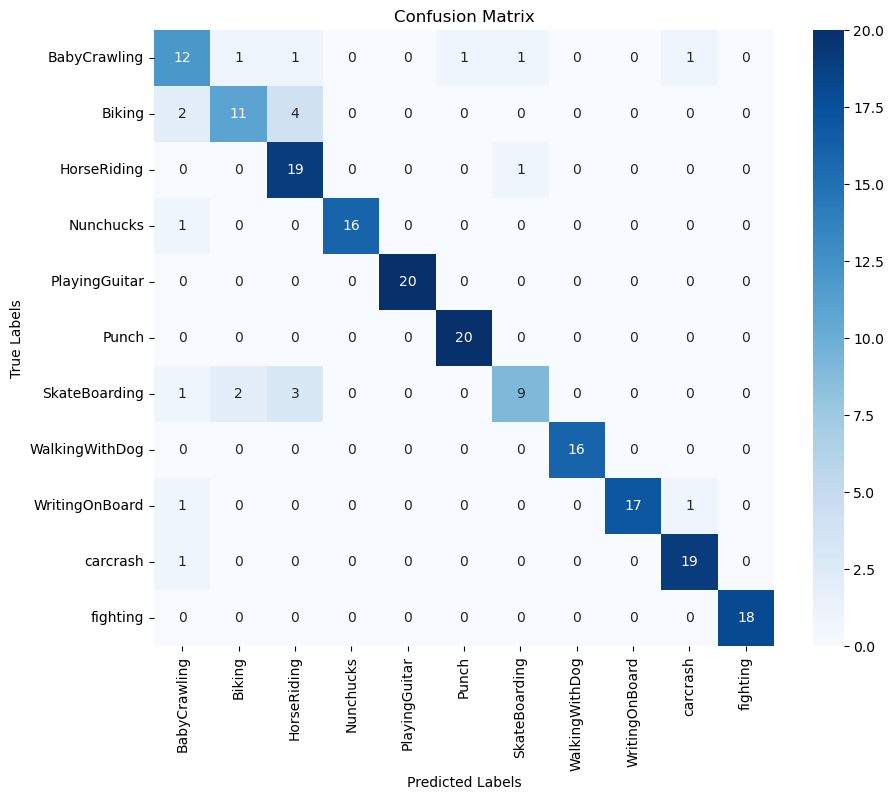

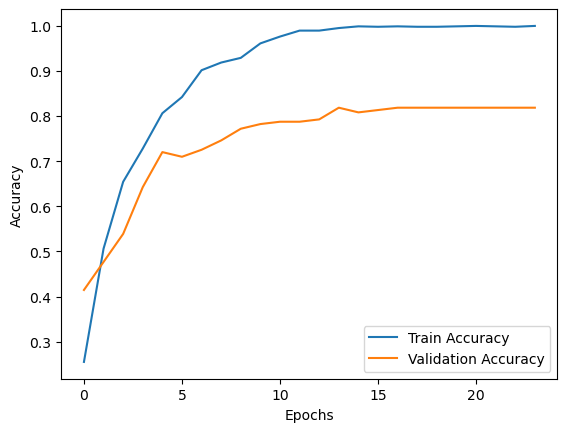

In [21]:
import seaborn as sns

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# Save the final model
model.save("mf.keras")
print("Model saved as 'mf.keras'")

Model saved as 'mf.keras'


In [28]:
# Access all weights of the model
weights = model.weights

# Print the shape of each weight tensor
for i, weight in enumerate(weights):
    print(f"Weight {i}: Shape = {weight.shape}")

Weight 0: Shape = (3, 3, 3, 3, 32)
Weight 1: Shape = (32,)
Weight 2: Shape = (3, 3, 3, 32, 64)
Weight 3: Shape = (64,)
Weight 4: Shape = (3, 3, 3, 64, 128)
Weight 5: Shape = (128,)
Weight 6: Shape = (8192, 512)
Weight 7: Shape = (128, 512)
Weight 8: Shape = (512,)
Weight 9: Shape = (128, 11)
Weight 10: Shape = (11,)


In [32]:
# Access the optimizer used in the model
optimizer = model.optimizer

# Print the learning rate
learning_rate = optimizer.learning_rate.numpy()
print(f"Learning Rate: {learning_rate}")

Learning Rate: 1.000000082740371e-07


In [34]:
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 40, 64, 64, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 20, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 20, 32, 32, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 10, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 10, 16, 16, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 5, 8, 8, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 5, 8192)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │       4,260,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,623,203 (51.97 MB)

 Trainable params: 4,541,067 (17.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,082,136 (34.65 MB)

In [3]:
aaa="""BabyCrawling       0.67      0.71      0.69        17
        Biking       0.79      0.65      0.71        17
   HorseRiding       0.70      0.95      0.81        20
     Nunchucks       1.00      0.94      0.97        17
 PlayingGuitar       1.00      1.00      1.00        20
         Punch       0.95      1.00      0.98        20
 SkateBoarding       0.82      0.60      0.69        15
WalkingWithDog       1.00      1.00      1.00        16
WritingOnBoard       1.00      0.89      0.94        19
      carcrash       0.90      0.95      0.93        20
      fighting       1.00      1.00      1.00        18""".splitlines()
zz=[]
for i in aaa:
    ccc=i.split()
    zz.append(ccc[0])
zz

['BabyCrawling',
 'Biking',
 'HorseRiding',
 'Nunchucks',
 'PlayingGuitar',
 'Punch',
 'SkateBoarding',
 'WalkingWithDog',
 'WritingOnBoard',
 'carcrash',
 'fighting']

In [19]:
from tensorflow.keras.models import load_model

# Load the model from the .keras file
m = load_model('m.keras')

In [23]:
# Path to save the .h5 weights file
H5_WEIGHTS_PATH = "mm.weights.h5"

# Save the model weights to an .h5 file
model.save_weights(H5_WEIGHTS_PATH)

print(f"Model weights saved to: {H5_WEIGHTS_PATH}")

Model weights saved to: mm.weights.h5


In [25]:
# Load the saved weights back into the model
model.load_weights(H5_WEIGHTS_PATH)

print("Weights loaded successfully!")

Weights loaded successfully!


In [9]:

from tensorflow.keras.models import load_model

# Load the model from the .keras file
model= load_model(r'C:\Users\salag\b11\m6.keras')
# Access the optimizer used in the model
optimizer = model.optimizer

# Print the learning rate
learning_rate = optimizer.learning_rate.numpy()
print(f"Learning Rate: {learning_rate}")

Learning Rate: 3.45794869645033e-05


In [10]:
# Frame extraction function
def extract_frames(video_path, img_size, sequence_length):
    frames_list = []
    print(video_path)
    video_reader = cv2.VideoCapture(video_path)
    
    # Check if the video file is accessible
    if not video_reader.isOpened():
        print(f"Failed to open video: {video_path}")
        return frames_list

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    print(f"Extracting frames from {video_path}...")
    print(f"Total frames in video: {video_frames_count}")
    print(f"Skip frames window: {skip_frames_window}")

    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            print(f"Failed to read frame {frame_counter} from {video_path}")
            break

        resized_frame = cv2.resize(frame, (img_size, img_size))
        normalized_frame = resized_frame / 255.0  # Normalize to range [0, 1]
        frames_list.append(normalized_frame)
    print("total frames extracted :", len(frames_list))
    video_reader.release()

    # Ensure the sequence length is correct
    if len(frames_list) != sequence_length:
        print(f"Warning: Expected {sequence_length} frames, but got {len(frames_list)} frames from {video_path}")

    return frames_list


1

In [16]:








# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)












NameError: name 'tf' is not defined

In [17]:
def build_model(input_shape, num_classes):
    model = Sequential()

    # 3D CNN layers
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))

    # Flatten and pass to LSTM
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    return model



1

In [19]:
# Build and compile model
print("Building model...")
model = build_model(input_shape, NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
checkpoint = ModelCheckpoint("m.keras", save_best_only=True, save_weights_only=False)

# Train model
print("Training model...")
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping, reduce_lr, checkpoint])


1

In [26]:
# Evaluate model on test set
print("Evaluating model on test set...")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

# Confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)






2

In [34]:
# Saving the model
model.save("m.keras")  # Save the model in HDF5 format (contains weights and architecture)


3